# Preprocesamiento

In [1]:
import os
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from sklearn.metrics import f1_score


In [2]:
# Función para cargar una imagen y su máscara
def load_image_and_mask(image_path, mask_path):
    image = Image.open(image_path).convert('RGB')
    mask = Image.open(mask_path)
    return np.array(image), np.array(mask)

In [3]:
#Función para cargar todas las imágenes y máscaras de un directorio
def resize_image(image, size=(256, 256)):
    return np.array(Image.fromarray(image).resize(size))

In [4]:
# Funciones para preprocesar las imágenes y máscaras

def preprocess_image(image):
    # Redimensionar la imagen
    resized_image = resize_image(image)
    # Normalizar los píxeles de la imagen
    normalized_image = resized_image.astype('float32') / 255.0
    return normalized_image

def preprocess_mask(mask, num_classes):
    resized_mask = resize_image(mask)
    resized_mask = resized_mask.astype(np.int32)
    resized_mask[resized_mask >= num_classes] = num_classes - 1
    return to_categorical(resized_mask, num_classes=num_classes)

In [5]:
# Directorio que contiene las imágenes y las máscaras (Cambiar por la ruta correcta si es necesario)
images_dir = '../RGB/images/'
masks_dir = '../RGB/masks/'

# Listas para almacenar las imágenes y máscaras preprocesadas
preprocessed_images = []
preprocessed_masks = []

# Recorrer todas las imágenes y máscaras
for image_file in os.listdir(images_dir):
    if image_file.endswith('.tif'):
        
        # Obtener los paths de la imagen y la máscara
        image_path = os.path.join(images_dir, image_file)
        mask_file = image_file.replace('.tif', '.tif')
        mask_path = os.path.join(masks_dir, mask_file)
        
        # Cargar la imagen y la máscara
        image, mask = load_image_and_mask(image_path, mask_path)
        
        # Preprocesar la imagen y la máscara
        preprocessed_image = preprocess_image(image)
        preprocessed_mask = preprocess_mask(mask, num_classes=5)
                
        # Agregar la imagen y la máscara preprocesadas
        preprocessed_images.append(preprocessed_image)
        preprocessed_masks.append(preprocessed_mask)

In [6]:
# Imprimir información sobre las imágenes y máscaras preprocesadas

print('Número de imágenes:', len(preprocessed_images))
print('Número de máscaras:', len(preprocessed_masks))

print('Tamaño de las imágenes:', preprocessed_images[0].shape)
print('Tamaño de las máscaras:', preprocessed_masks[0].shape)

Número de imágenes: 41
Número de máscaras: 41
Tamaño de las imágenes: (256, 256, 3)
Tamaño de las máscaras: (256, 256, 5)


In [7]:
# Convertir las listas a arrays numpy
preprocessed_images = np.array(preprocessed_images)
preprocessed_masks = np.array(preprocessed_masks)

# Dividir los datos en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(preprocessed_images, preprocessed_masks, test_size=0.2, random_state=42)

# Imprimir información sobre los conjuntos
print('Número de imágenes de entrenamiento:', len(X_train))
print('Número de imágenes de validación:', len(X_val))
print('Forma de las imágenes:', X_train.shape)
print('Forma de las máscaras:', y_train.shape)

Número de imágenes de entrenamiento: 32
Número de imágenes de validación: 9
Forma de las imágenes: (32, 256, 256, 3)
Forma de las máscaras: (32, 256, 256, 5)


# Modelo

In [8]:
# Definir la arquitectura de la red U-Net

def unet_model(input_shape=(256, 256, 3), num_classes=5):

    # Definir la entrada
    inputs = Input(input_shape)
    
    # Codificación (downsampling)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Capa central
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decodificación (upsampling)
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv4], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Capa de salida
    outputs = Conv2D(num_classes, 1, activation='softmax')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Número de clases
num_classes = 5

# Construir el modelo
model = unet_model(input_shape=(256, 256, 3), num_classes=num_classes)

# Definiendo la función de pérdida Focal Loss
class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=2.0, alpha=0.25):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
    
    def call(self, y_true, y_pred):
        
        # Ajustar y_pred para evitar log(0)
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1.0 - tf.keras.backend.epsilon())
        
        # Calcular la entropía cruzada
        cross_entropy = -y_true * tf.math.log(y_pred)
        # Calcular la pérdida focal
        loss = self.alpha * tf.math.pow(1 - y_pred, self.gamma) * cross_entropy
        
        return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))

# Uso de Focal Loss
loss_fn = FocalLoss(gamma=2.0, alpha=0.25)

# Compilar el modelo con los pesos de clase
model.compile(optimizer='Adam', loss=loss_fn, metrics=['accuracy'])

In [9]:
# Entrenar el modelo
history = model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=5,
    validation_data=(X_val, y_val)
    
)

Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 30s 14s/step - accuracy: 0.3545 - loss: 0.2491 - val_accuracy: 0.4735 - val_loss: 0.1962
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 28s 15s/step - accuracy: 0.4646 - loss: 0.1925 - val_accuracy: 0.5118 - val_loss: 0.1561
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 27s 14s/step - accuracy: 0.4946 - loss: 0.1532 - val_accuracy: 0.5131 - val_loss: 0.1567
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 27s 14s/step - accuracy: 0.5047 - loss: 0.1543 - val_accuracy: 0.5120 - val_loss: 0.1505
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 28s 15s/step - accuracy: 0.5186 - loss: 0.1504 - val_accuracy: 0.5276 - val_loss: 0.1485


# Metricas

In [10]:
# Evaluar el modelo en el conjunto de validación
evaluation = model.evaluate(X_val, y_val)

# Obtener las métricas de evaluación
loss = evaluation[0]
accuracy = evaluation[1]

# Imprimir las métricas de evaluación
print("Loss:", loss)
print("Accuracy:", accuracy)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5276 - loss: 0.1485
Loss: 0.1484621912240982
Accuracy: 0.5276319980621338


In [11]:
# Obtener las predicciones del modelo en el conjunto de validación
y_pred = model.predict(X_val)

# Convertir las predicciones a la clase más probable
y_pred_argmax = np.argmax(y_pred, axis=-1)
y_val_argmax = np.argmax(y_val, axis=-1)

# Imprimir las clases únicas en las predicciones
unique_classes, counts = np.unique(y_pred_argmax, return_counts=True)
print(f"Unique classes in predictions: {unique_classes}")
print(f"Counts of each class: {counts}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Unique classes in predictions: [0 2]
Counts of each class: [564081  25743]


In [12]:
# Calcular el F1-Score
f1 = f1_score(y_val_argmax.flatten(), y_pred_argmax.flatten(), average='weighted')

# Imprimir el F1-Score
print("F1-Score:", f1)

F1-Score: 0.3956700608835231


In [13]:
# Función para calcular el IoU (Intersection over Union) para cada clase
def calculate_iou(y_true, y_pred, num_classes):
    iou = []
    for cls in range(num_classes):
        true_class = y_true == cls
        pred_class = y_pred == cls
        intersection = np.sum(np.logical_and(true_class, pred_class))
        union = np.sum(np.logical_or(true_class, pred_class))
        if union == 0:
            iou.append(float('nan')) 
        else:
            iou.append(intersection / union)
    return iou

# Calcular IoU para cada clase
iou_per_class = calculate_iou(y_val_argmax, y_pred_argmax, num_classes=5)

# Imprimir el IoU para cada clase
for cls in range(num_classes):
    print(f"IoU for class {cls}: {iou_per_class[cls]}")

IoU for class 0: 0.5195644621922163
IoU for class 1: 0.0
IoU for class 2: 0.06863713543065501
IoU for class 3: 0.0
IoU for class 4: 0.0


# Visualización

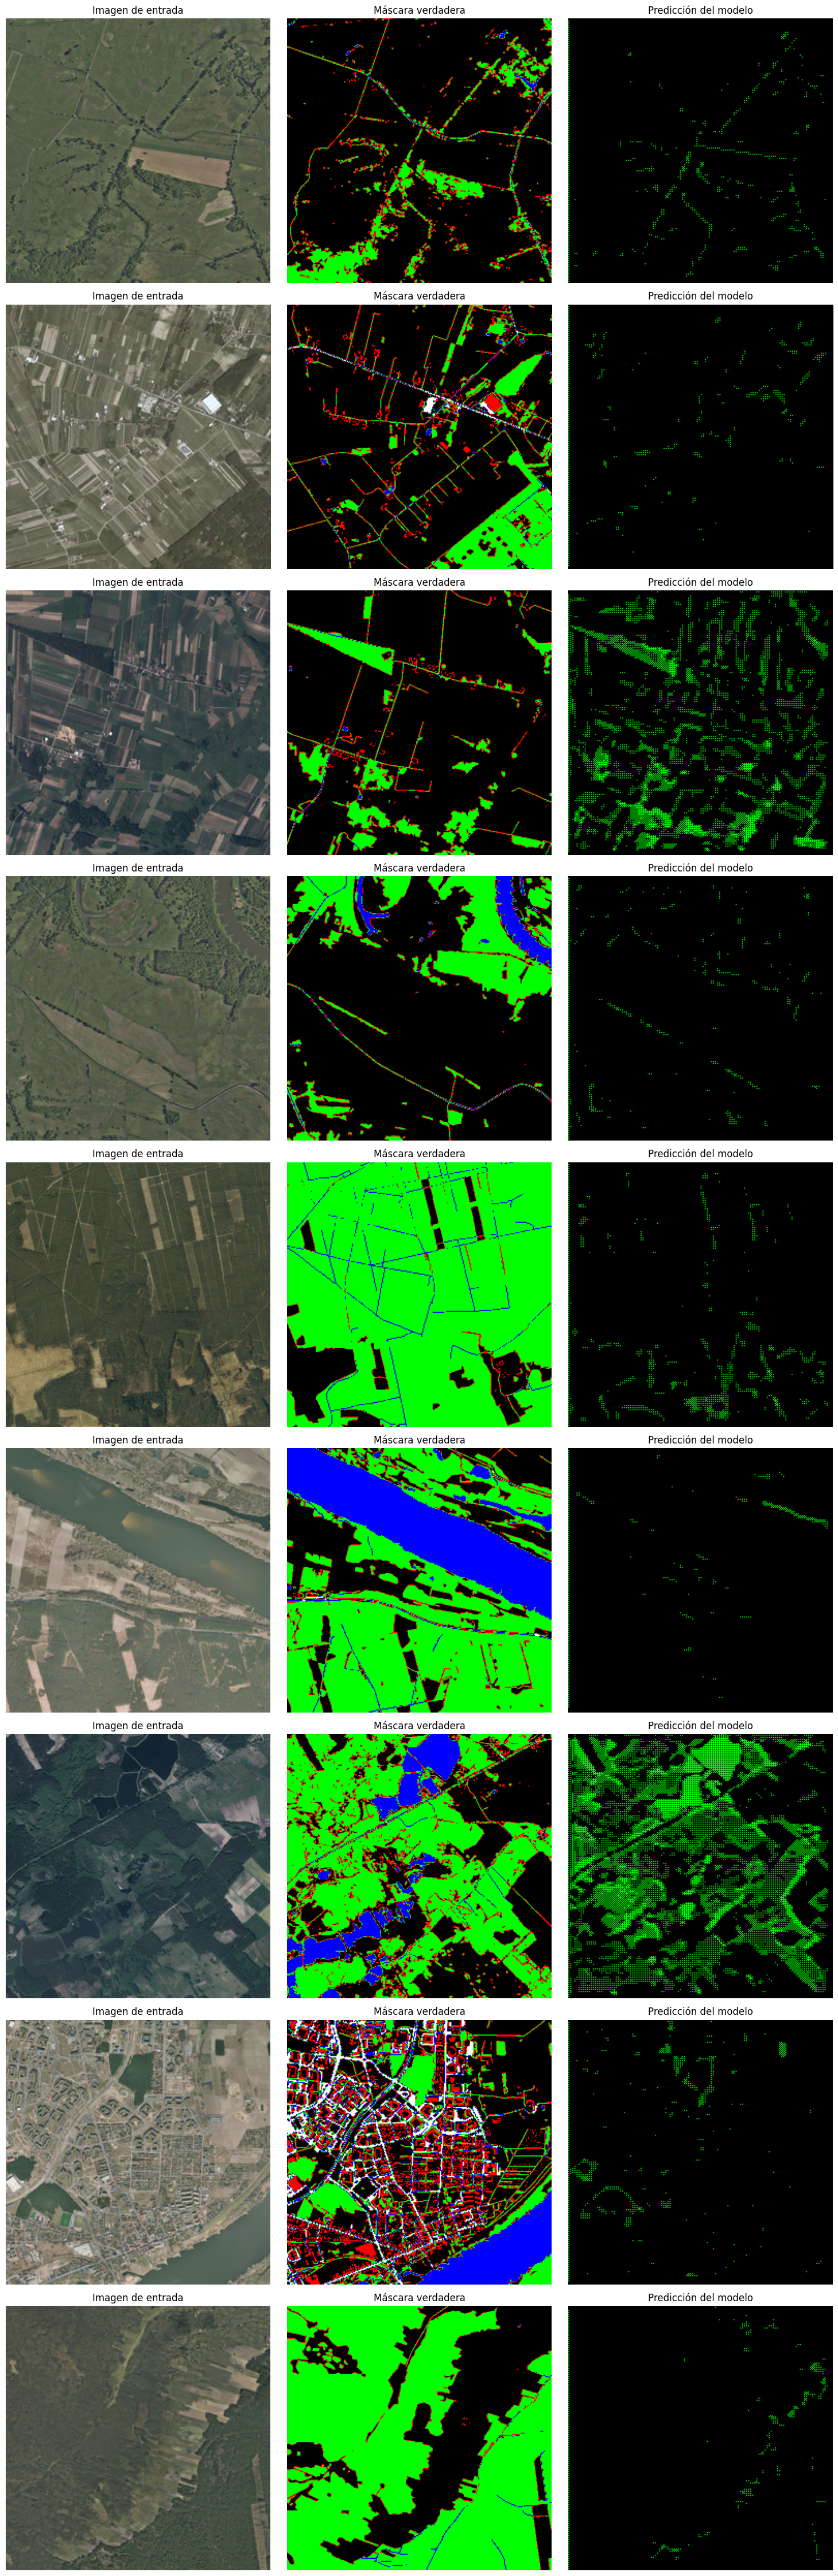

In [14]:
# Definir colores para las clases
colors = [
    [0, 0, 0],       # Negro, probablemente áreas con poca vegetación o sin
    [255, 0, 0],     # Rojo, probablemente para edificaciones
    [0, 255, 0],     # Verde, probablemente para vegetación
    [0, 0, 255],     # Azul, probablemente agua
    [255, 255, 255]  # Blanco, probablemente caminos
]

# Función para convertir la máscara a una imagen colorida
def mask_to_colored_image(mask, colors):
    height, width = mask.shape
    colored_image = np.zeros((height, width, 3), dtype=np.uint8)
    for class_id, color in enumerate(colors):
        colored_image[mask == class_id] = color
    return colored_image

# Función para visualizar las imágenes, máscaras y predicciones
def display_results(X_val, y_val, y_pred, num_images=5):
    plt.figure(figsize=(15, num_images * 5))
    
    for i in range(num_images):
        # Imagen de entrada
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.title('Imagen de entrada')
        plt.imshow(X_val[i])
        plt.axis('off')

        # Máscara verdadera
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.title('Máscara verdadera')
        y_val_colored = mask_to_colored_image(y_val[i], colors)
        plt.imshow(y_val_colored)
        plt.axis('off')
        
        # Predicción del modelo
        plt.subplot(num_images, 3, i * 3 + 3)
        plt.title('Predicción del modelo')
        y_pred_colored = mask_to_colored_image(y_pred[i], colors)
        plt.imshow(y_pred_colored)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualizar los resultados
display_results(X_val, y_val_argmax, y_pred_argmax, num_images=9)
